### Your name:

<pre> Gibran Alva Sierra</pre>

### Collaborators:

<pre> Enter the name of the people you worked with if any</pre>


# Assignment for Module 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [88]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [89]:
import requests

url = 'https://archive.ics.uci.edu/static/public/321/electricityloaddiagrams20112014.zip'
local_zip_path = 'electricityloaddiagrams20112014.zip'

# Download the dataset
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(local_zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)
    print(f"Dataset downloaded and saved to {local_zip_path}")
else:
    print("Failed to download the dataset. Please check the URL.")



Dataset downloaded and saved to electricityloaddiagrams20112014.zip


In [90]:
import pandas as pd
import zipfile

local_zip_path = 'electricityloaddiagrams20112014.zip'
output_csv_path = 'processed_data.csv'

# Extract and process the dataset in chunks
def process_chunk(chunk):
    # Replace commas with periods
    chunk = chunk.replace(',', '.', regex=True)
    # Convert all columns except the first to numeric, coerce errors to NaN
    chunk.iloc[:, 1:] = chunk.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
    return chunk

with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    file_name = zip_ref.namelist()[0]
    with zip_ref.open(file_name) as file:
        chunk_iter = pd.read_csv(file, delimiter=';', low_memory=False, chunksize=5000)
        
        for i, chunk in enumerate(chunk_iter):
            processed_chunk = process_chunk(chunk)
            if i == 0:
                processed_chunk.to_csv(output_csv_path, index=False)
            else:
                processed_chunk.to_csv(output_csv_path, mode='a', header=False, index=False)

print(f"Data processed and saved to {output_csv_path}")



Data processed and saved to processed_data.csv


In [91]:
import pandas as pd

# Load the processed data
data = pd.read_csv('processed_data.csv')

# Inspect the first column which is expected to be the datetime information
print("First few rows of the data with datetime column:")
print(data.iloc[:, 0].head())

# Convert the first column to datetime
data.iloc[:, 0] = pd.to_datetime(data.iloc[:, 0], errors='coerce')

# Drop rows where the first column couldn't be converted
data = data.dropna(subset=[data.columns[0]])

# Set the first column as the index
data = data.set_index(data.columns[0])

# Verify the index
print("Index after cleaning:", data.index)



First few rows of the data with datetime column:
0    2011-01-01 00:15:00
1    2011-01-01 00:30:00
2    2011-01-01 00:45:00
3    2011-01-01 01:00:00
4    2011-01-01 01:15:00
Name: Unnamed: 0, dtype: object
Index after cleaning: DatetimeIndex(['2011-01-01 00:15:00', '2011-01-01 00:30:00',
               '2011-01-01 00:45:00', '2011-01-01 01:00:00',
               '2011-01-01 01:15:00', '2011-01-01 01:30:00',
               '2011-01-01 01:45:00', '2011-01-01 02:00:00',
               '2011-01-01 02:15:00', '2011-01-01 02:30:00',
               ...
               '2014-12-31 21:45:00', '2014-12-31 22:00:00',
               '2014-12-31 22:15:00', '2014-12-31 22:30:00',
               '2014-12-31 22:45:00', '2014-12-31 23:00:00',
               '2014-12-31 23:15:00', '2014-12-31 23:30:00',
               '2014-12-31 23:45:00', '2015-01-01 00:00:00'],
              dtype='datetime64[ns]', name='Unnamed: 0', length=140256, freq=None)


C:\Users\gibra\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


### Quick data inspection

In [92]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [94]:
data.shape

(140256, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0 MB


In [96]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the 2 days of 2012 for the first 2 clients

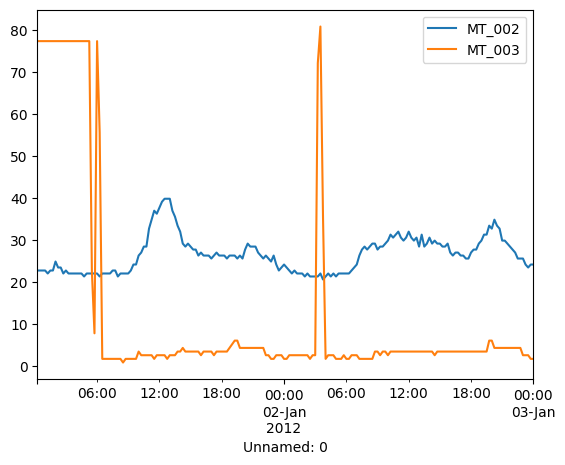

In [97]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_002','MT_003']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [98]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [99]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [100]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [102]:
import pandas as pd

# data2011, data2013, and data2014 are already defined DataFrames
clients = data2011.columns
clients_no_demand = clients[data2013.mean() == 0]  # clients with 0 demand
# Append 2013 and 2014 data using pd.concat
data_13_14 = pd.concat([data2013, data2014])
# Drop clients with 0 demand
data_13_14 = data_13_14.drop(clients_no_demand, axis=1)
# Print the shape of the resulting DataFrame
print(data_13_14.shape)
print(sum(data_13_14.mean() == 0))


(70080, 349)
0


## Getting average curves per client

In [103]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [106]:
# Extract the hour from the datetime index
data['hour'] = data.index.hour
# Verify the changes
print(data[['hour']].head())

                     hour
Unnamed: 0               
2013-01-01 00:15:00     0
2013-01-01 00:30:00     0
2013-01-01 00:45:00     0
2013-01-01 01:00:00     1
2013-01-01 01:15:00     1


In [107]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,0
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,0
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,0


### Getting average curves per client

In [108]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(24, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [109]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

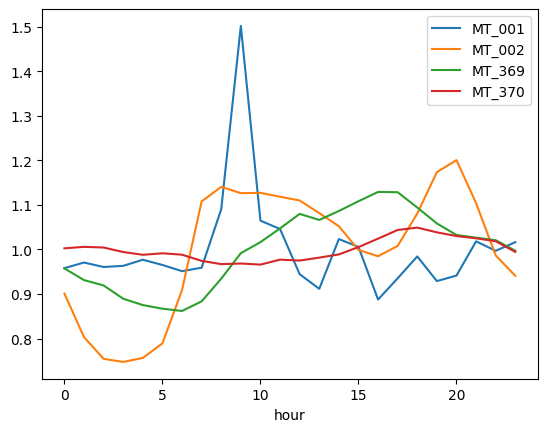

In [110]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [111]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it on the right format

## Exercise 1:

a. Using the functions described in Module 2, determine what a convenient number of clusters based on _intertia_ and based on _silhouette_. Justify your choice

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

In [115]:
from sklearn.decomposition import PCA
import numpy as np

# Reduce dimensions to speed up clustering
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)


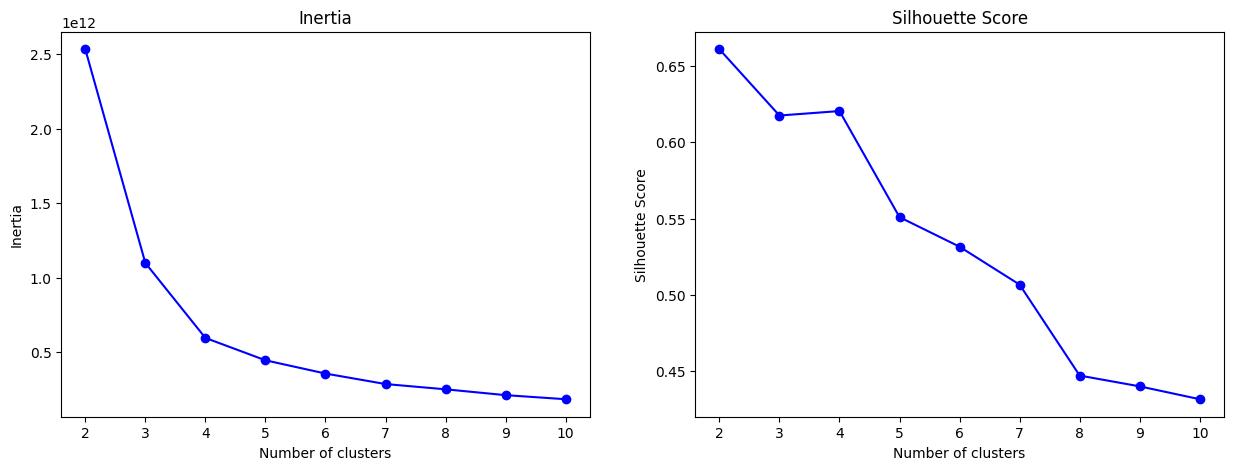

In [116]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Sample a subset of data for quicker analysis
np.random.seed(42)
sample_indices = np.random.choice(data_pca.shape[0], size=int(0.1 * data_pca.shape[0]), replace=False)
data_sample = data_pca[sample_indices]

range_n_clusters = list(range(2, 11))
inertia = []
silhouette = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data_sample)
    inertia.append(kmeans.inertia_)
    cluster_labels = kmeans.predict(data_sample)
    silhouette.append(silhouette_score(data_sample, cluster_labels))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range_n_clusters, inertia, 'bo-')
ax1.set_title('Inertia')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')

ax2.plot(range_n_clusters, silhouette, 'bo-')
ax2.set_title('Silhouette Score')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')

plt.show()



By Observing the diferent plots, we can determine that the best number for cluster is 3. In both cases we can se significal diference from cluster 2 to 3. In the Inertia there is a huge drop, meanwhile in the Silhouette the next poin there is a peak.

C:\Users\gibra\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


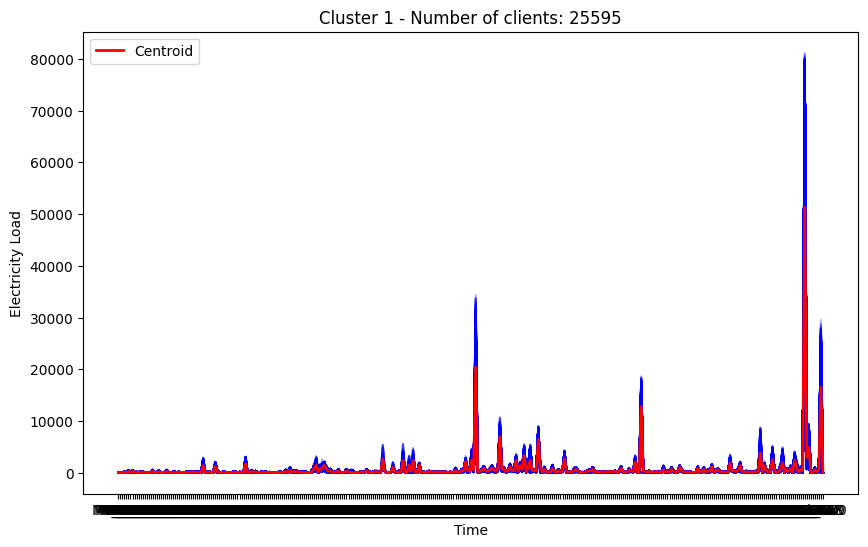

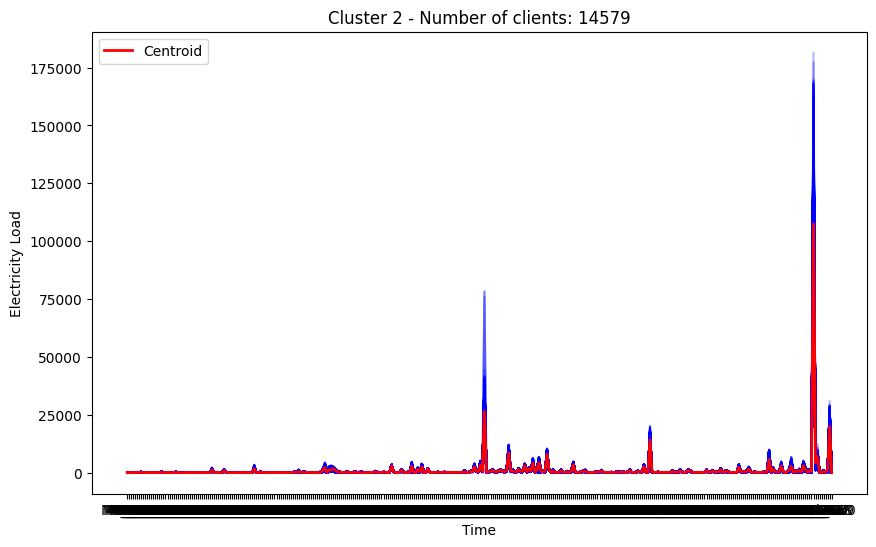

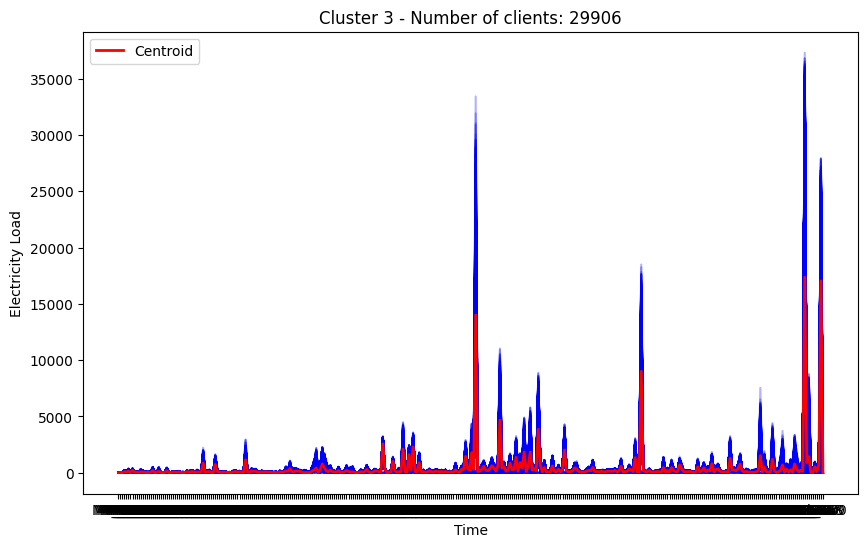

In [118]:
optimal_clusters = 3  # Based on the plots

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(data)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

for cluster in range(optimal_clusters):
    cluster_data = data[labels == cluster]
    centroid = centroids[cluster]

    plt.figure(figsize=(10, 6))
    
    # Plot all curves in the cluster
    for i in range(cluster_data.shape[0]):
        plt.plot(cluster_data.iloc[i, :], color='blue', alpha=0.3)
    
    # Plot the centroid curve
    plt.plot(centroid, color='red', linewidth=2, label='Centroid')
    
    plt.title(f'Cluster {cluster + 1} - Number of clients: {cluster_data.shape[0]}')
    plt.xlabel('Time')
    plt.ylabel('Electricity Load')
    plt.legend()
    plt.show()


## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [121]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

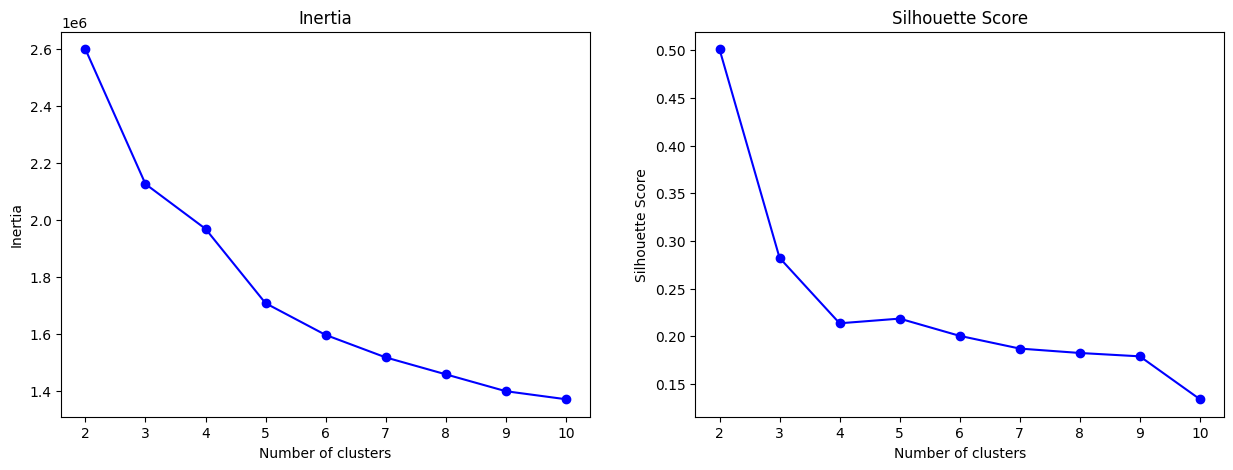

In [122]:
# Convert list of arrays to a numpy array
X = np.array(X)

# Determine the optimal value for k-means using inertia and silhouette score
range_n_clusters = list(range(2, 11))
inertia = []
silhouette = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    cluster_labels = kmeans.predict(X)
    silhouette.append(silhouette_score(X, cluster_labels))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range_n_clusters, inertia, 'bo-')
ax1.set_title('Inertia')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')

ax2.plot(range_n_clusters, silhouette, 'bo-')
ax2.set_title('Silhouette Score')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')

plt.show()


#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [123]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

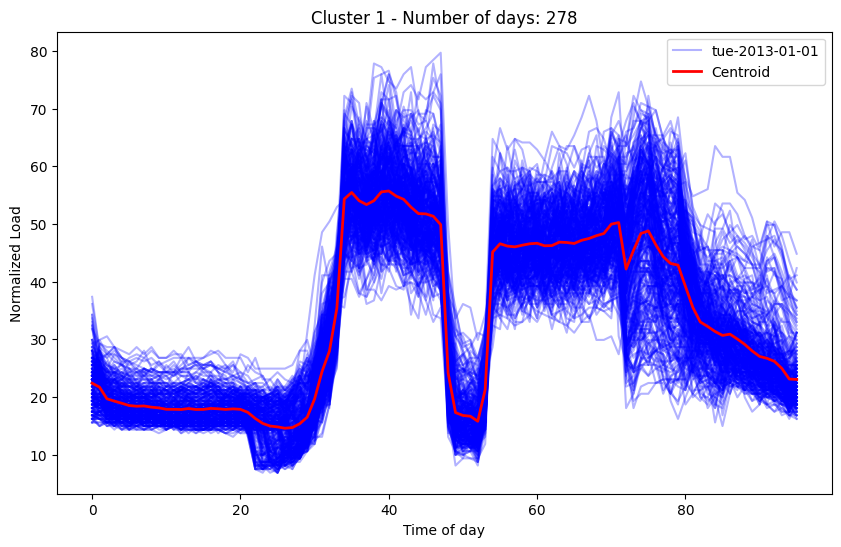

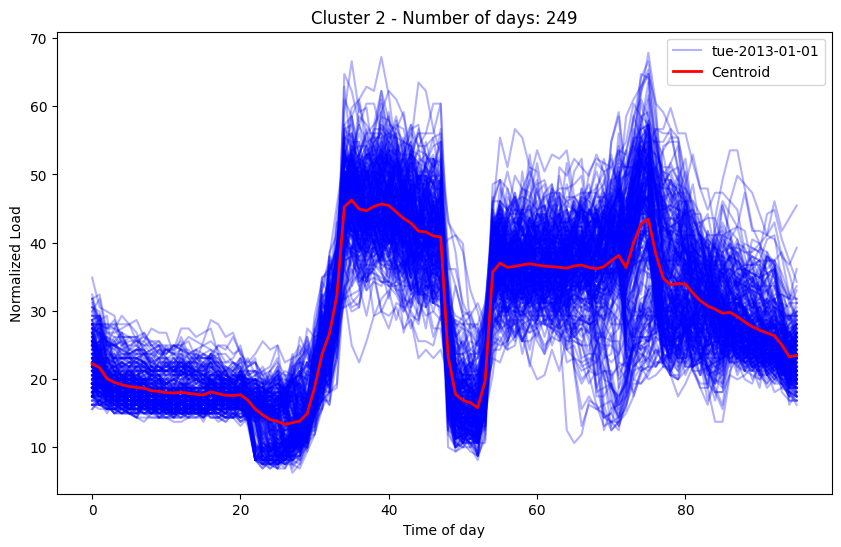

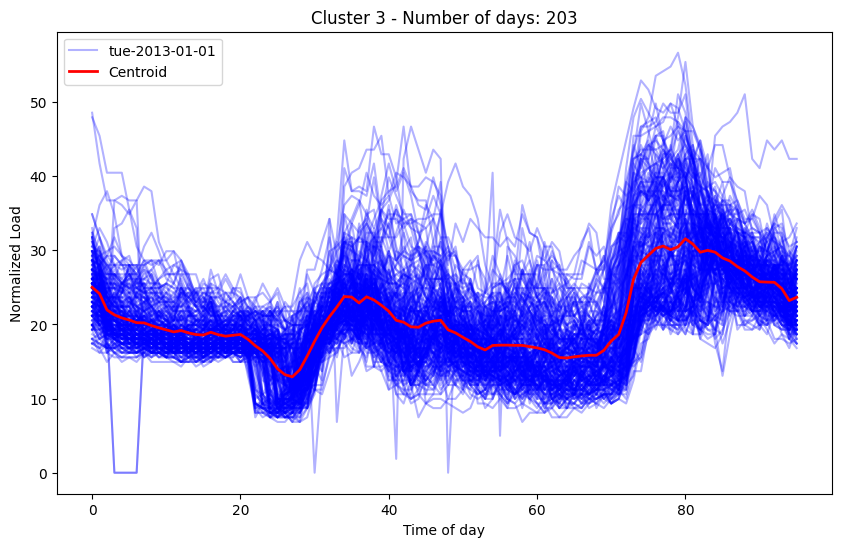

In [124]:
optimal_clusters = 3  # Replace with the optimal number determined

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

for cluster in range(optimal_clusters):
    cluster_data = X[labels == cluster]
    centroid = centroids[cluster]

    plt.figure(figsize=(10, 6))
    
    # Plot all curves in the cluster
    for i, curve in enumerate(cluster_data):
        day_label = daysyear[i]
        plt.plot(curve, color='blue', alpha=0.3, label=day_label if i == 0 else "")

    # Plot the centroid curve
    plt.plot(centroid, color='red', linewidth=2, label='Centroid')
    
    plt.title(f'Cluster {cluster + 1} - Number of days: {len(cluster_data)}')
    plt.xlabel('Time of day')
    plt.ylabel('Normalized Load')
    plt.legend()
    plt.show()


#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [125]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]

The images above represent the usage patterns each client has.  By analyzing the centroid and the individual curves in each cluster, you can identify common usage behaviors and potentially identify patterns related to weekdays, weekends, or specific dates.As in excersise 1 the ideal number of clusters is 3. We can observe that by the drop it appears in both plots.